In [2]:
import numpy as np

In [3]:
def create_multi_horizon_windows(data, input_window=14, output_window=7):
    X, y = [], []
    for i in range(len(data) - input_window - output_window + 1):
        X.append(data[i:i+input_window])
        y.append(data[i+input_window:i+input_window+output_window])
    return np.array(X), np.array(y)

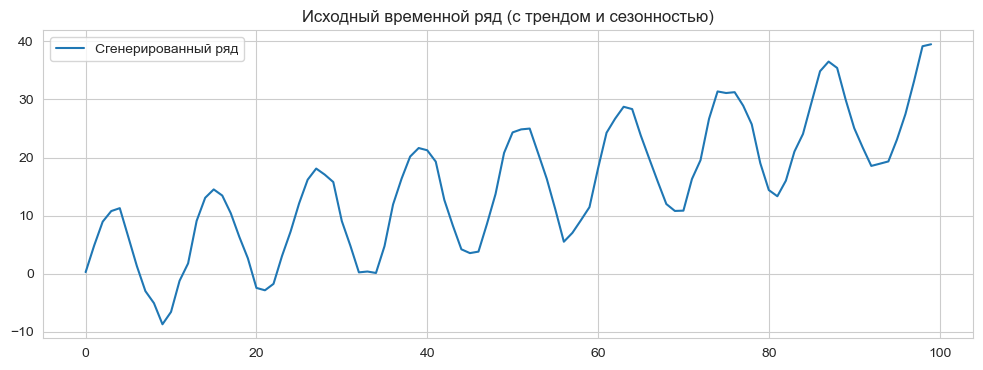

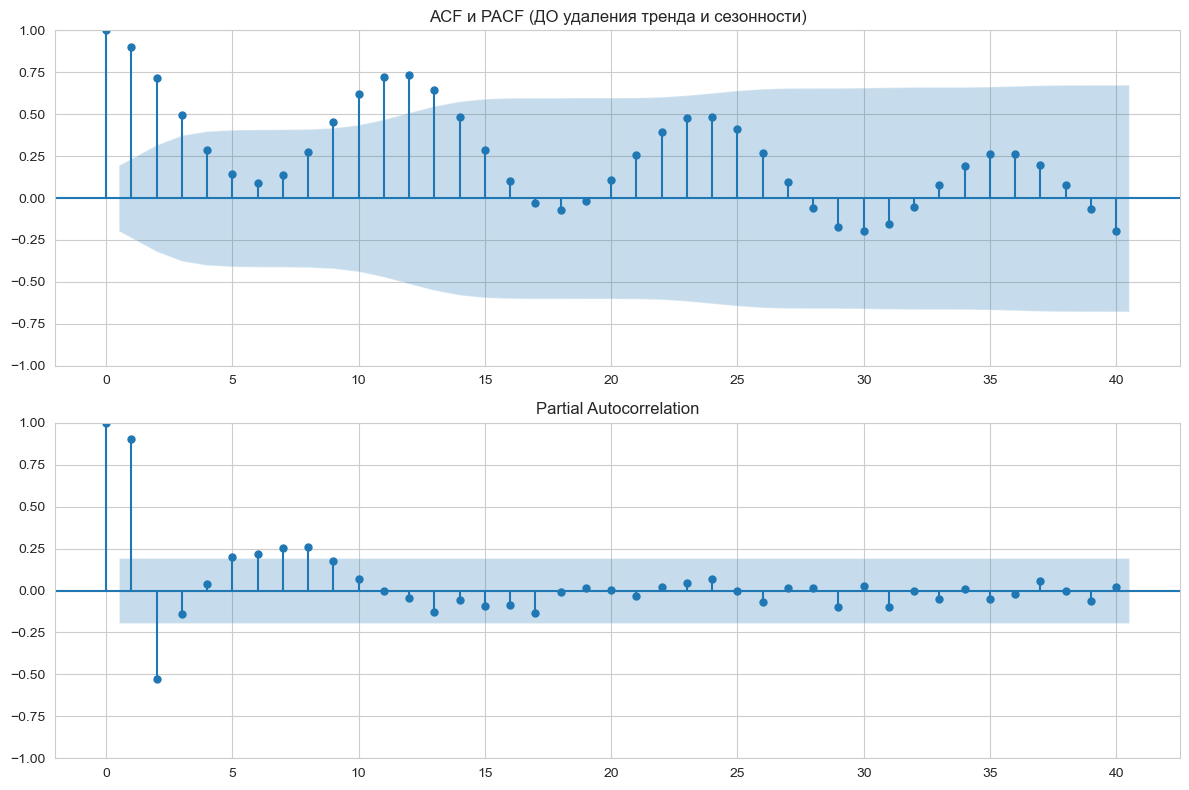

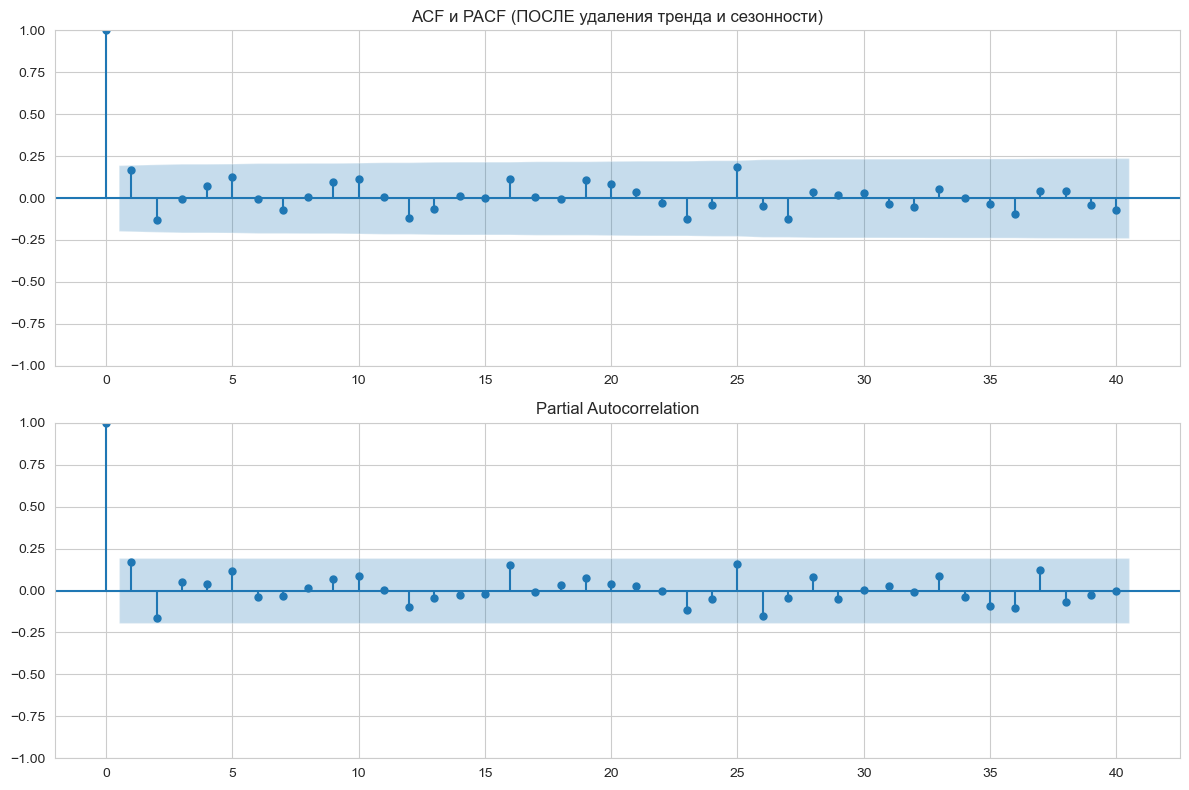

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

sns.set_style("whitegrid")

# 1. Генерируем временной ряд
t = np.arange(100)
seasonality = 10 * np.sin(2 * np.pi * t / 12)  # Сезонность с периодом 12
trend = 0.3 * t  # Линейный тренд
noise = np.random.normal(0, 1, size=100)
y = trend + seasonality + noise

# Делаем DataFrame
df = pd.DataFrame({'Time': t, 'Series': y})

# 2. Визуализация исходного ряда
plt.figure(figsize=(12, 4))
plt.plot(df['Series'], label='Сгенерированный ряд')
plt.title('Исходный временной ряд (с трендом и сезонностью)')
plt.legend()
plt.show()

# 3. ACF и PACF до обработки
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Series'], lags=40, ax=axes[0])
plot_pacf(df['Series'], lags=40, ax=axes[1])
axes[0].set_title('ACF и PACF (ДО удаления тренда и сезонности)')
plt.tight_layout()
plt.show()

# 4. Убираем тренд и сезонность

# Убираем тренд методом линейной регрессии
from sklearn.linear_model import LinearRegression

X = df[['Time']]
y_raw = df['Series']
model = LinearRegression()
model.fit(X, y_raw)
trend_pred = model.predict(X)
detrended = y_raw - trend_pred

# Теперь убираем сезонность (просто вычитаем повторяющийся паттерн)
seasonal_period = 12
seasonal_avg = [np.mean(detrended[i::seasonal_period]) for i in range(seasonal_period)]
seasonal_corrected = np.array([detrended[i] - seasonal_avg[i % seasonal_period] for i in range(len(detrended))])

# Сохраняем очищенный ряд
df_clean = pd.Series(seasonal_corrected)

# 5. ACF и PACF после обработки
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_clean, lags=40, ax=axes[0])
plot_pacf(df_clean, lags=40, ax=axes[1])
axes[0].set_title('ACF и PACF (ПОСЛЕ удаления тренда и сезонности)')
plt.tight_layout()
plt.show()

---

endog shape: (7,)
exog shape: (7, 2)

Оцененные параметры:
[ 1.00003217e+00  4.60409946e-01 -3.83941085e-01 -3.38240706e-06
  1.64979577e+00]

Оценённые значения NAIRU по годам:
Период 0: 6.18
Период 1: 5.85
Период 2: 5.99
Период 3: 4.81
Период 4: 6.10
Период 5: 8.99
Период 6: 11.18


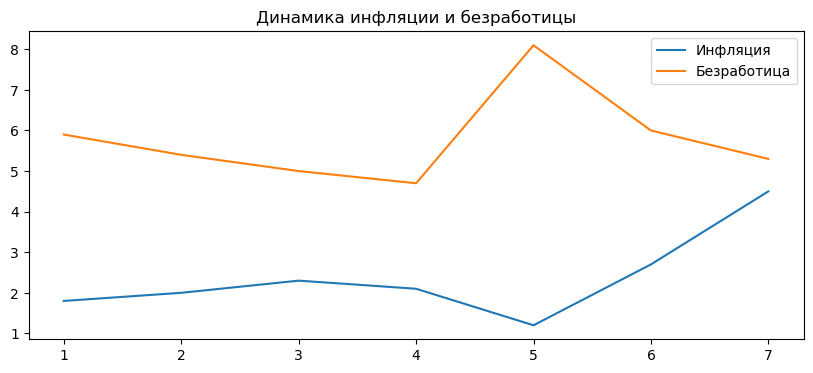

In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.sm_exceptions import ValueWarning
    
import matplotlib.pyplot as plt
import warnings

# Подавляем предупреждения
warnings.simplefilter('ignore', ValueWarning)

# Пример данных
inflation = np.array([1.5, 1.8, 2.0, 2.3, 2.1, 1.2, 2.7, 4.5])  # инфляция
unemployment = np.array([6.2, 5.9, 5.4, 5.0, 4.7, 8.1, 6.0, 5.3])  # безработица

# Создаем DataFrame и добавляем лаг инфляции
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment
})
df['inflation_lag'] = df['inflation'].shift(1)
df.dropna(inplace=True)

y = df['inflation'].values
X = df[['inflation_lag', 'unemployment']].values

# Проверяем размерности
print("endog shape:", y.shape)
print("exog shape:", X.shape)

# Класс модели NAIRU с фильтром Калмана
class NAIRUModel(MLEModel):
    start_params = [1.0, 0.5, -0.5, 0.1, 0.1]  # Начальные параметры
    param_names = ['const', 'alpha', 'beta', 'sigma_eps', 'sigma_eta']

    def __init__(self, endog, exog=None, **kwargs):
        self.exog = exog
        self.k_exog = exog.shape[1] if exog is not None else 0

        super(NAIRUModel, self).__init__(endog=endog, exog=exog, k_states=1, **kwargs)

        # Инициализация матриц
        nobs = len(endog)
        self['design'] = np.zeros((1, 1, nobs))  # Z
        self['transition'] = np.array([[1.0]])    # T
        self['selection'] = np.array([[1.0]])     # R
        self['obs_cov'] = np.array([[1.0]])       # H
        self['obs_intercept'] = np.zeros((1, nobs))  # c
        self['state_cov'] = np.array([[1.0]])      # Q
        
        self.initialize_approximate_diffuse()

    def update(self, params, **kwargs):
        const, alpha, beta, sigma_eps, sigma_eta = params

        # design matrix (Z): влияние NAIRU_t на инфляцию
        self['design', 0, 0, :] = -beta  # π_t зависит от NAIRU_t через β

        if self.exog is not None:
            pi_t_lag = self.exog[:, 0]
            u_t = self.exog[:, 1]
            self['obs_intercept', 0, :] = const + alpha * pi_t_lag + beta * u_t
        else:
            self['obs_intercept', 0, :] = const

        # Шумы
        self['state_cov', 0, 0] = sigma_eta**2
        self['obs_cov', 0, 0] = sigma_eps**2

# Создаем модель
model = NAIRUModel(endog=y, exog=X)

# Оцениваем параметры
res = model.fit(method='lbfgs', maxiter=200, disp=False)

# Выводим результаты
print("\nОцененные параметры:")
print(res.params)

# Получаем оценки NAIRU
nairu_estimated = res.smoothed_state[0]

print("\nОценённые значения NAIRU по годам:")
for i, val in enumerate(nairu_estimated):
    print(f"Период {i}: {val:.2f}")


plt.figure(figsize=(10, 4))
plt.plot(df.index, df['inflation'], label='Инфляция')
plt.plot(df.index, df['unemployment'], label='Безработица')
plt.legend()
plt.title('Динамика инфляции и безработицы')
plt.show()

In [33]:
unemployment[:-1] - nairu_estimated

array([ 0.01518309,  0.0540203 , -0.58751594,  0.19314778, -1.40257622,
       -0.88867702, -5.17814398])

## Экономическая интерпретация:

### Если $u_t < \text{NAIRU}_t$ → создаётся **инфляционное давление**

- В периоды **2, 4, 5, 6**: уровень безработицы ниже NAIRU → инфляция растёт (или будет расти)
- Например, в **период 6**: безработица = 6.0, NAIRU = 11.18 → большая разница → **сильное инфляционное давление**

### Если $u_t > \text{NAIRU}_t$ → создаётся **дефляционное давление**

- В **периоды 0, 1, 3**: безработица чуть выше NAIRU → инфляция снижается или стабильна



endog shape: (7,)
exog shape: (7, 3)

Оцененные параметры:
[ 9.99566354e-01  4.98455160e-01 -1.80130104e-06  8.89508293e-03
  1.10002327e+00  2.63146739e-01]

Оценённые значения NAIRU по годам:
Период 0: -1.07
Период 1: -1.07
Период 2: -1.07
Период 3: -1.07
Период 4: -1.07
Период 5: -1.07
Период 6: -1.07


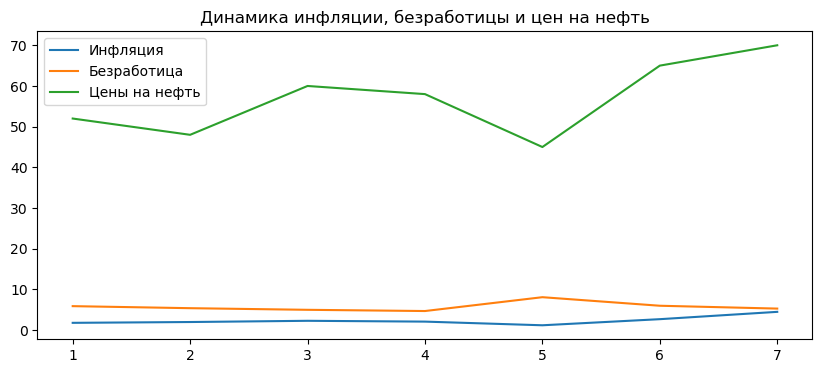

In [41]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tools.sm_exceptions import ValueWarning
import matplotlib.pyplot as plt
import warnings

# Подавляем предупреждения
warnings.simplefilter('ignore', ValueWarning)

# Пример данных
inflation = np.array([1.5, 1.8, 2.0, 2.3, 2.1, 1.2, 2.7, 4.5])  # инфляция
unemployment = np.array([6.2, 5.9, 5.4, 5.0, 4.7, 8.1, 6.0, 5.3])  # безработица
oil_prices = np.array([50, 52, 48, 60, 58, 45, 65, 70])  # цены на нефть как новая экзогенная переменная

# Создаем DataFrame и добавляем лаг инфляции
df = pd.DataFrame({
    'inflation': inflation,
    'unemployment': unemployment,
    'oil_prices': oil_prices
})
df['inflation_lag'] = df['inflation'].shift(1)
df.dropna(inplace=True)

y = df['inflation'].values
X = df[['inflation_lag', 'unemployment', 'oil_prices']].values  # Теперь три столбца

# Проверяем размерности
print("endog shape:", y.shape)
print("exog shape:", X.shape)

# Класс модели NAIRU с фильтром Калмана
class NAIRUModel(MLEModel):
    start_params = [1.0, 0.5, -0.5, 0.1, 0.1, 0.1]  # Новый старт: const, alpha, beta, gamma, sigma_eps, sigma_eta
    param_names = ['const', 'alpha', 'beta', 'gamma', 'sigma_eps', 'sigma_eta']

    def __init__(self, endog, exog=None, **kwargs):
        self.exog = exog
        self.k_exog = exog.shape[1] if exog is not None else 0

        super(NAIRUModel, self).__init__(endog=endog, exog=exog, k_states=1, **kwargs)

        nobs = len(endog)
        self['design'] = np.zeros((1, 1, nobs))         # Z
        self['transition'] = np.array([[1.0]])          # T
        self['selection'] = np.array([[1.0]])           # R
        self['obs_cov'] = np.array([[1.0]])             # H
        self['obs_intercept'] = np.zeros((1, nobs))     # c
        self['state_cov'] = np.array([[1.0]])           # Q

        self.initialize_approximate_diffuse()

    def update(self, params, **kwargs):
        const, alpha, beta, gamma, sigma_eps, sigma_eta = params

        # design matrix (Z): влияние NAIRU_t на инфляцию
        self['design', 0, 0, :] = -beta  # π_t зависит от NAIRU_t через β

        if self.exog is not None:
            pi_t_lag = self.exog[:, 0]
            u_t = self.exog[:, 1]
            oil_t = self.exog[:, 2]
            self['obs_intercept', 0, :] = const + alpha * pi_t_lag + beta * u_t + gamma * oil_t
        else:
            self['obs_intercept', 0, :] = const

        # Шумы
        self['state_cov', 0, 0] = sigma_eta**2
        self['obs_cov', 0, 0] = sigma_eps**2

# Создаем модель
model = NAIRUModel(endog=y, exog=X)

# Оцениваем параметры
res = model.fit(method='lbfgs', maxiter=200, disp=False)

# Выводим результаты
print("\nОцененные параметры:")
print(res.params)

# Получаем оценки NAIRU
nairu_estimated = res.smoothed_state[0]

print("\nОценённые значения NAIRU по годам:")
for i, val in enumerate(nairu_estimated):
    print(f"Период {i}: {val:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(df.index, df['inflation'], label='Инфляция')
plt.plot(df.index, df['unemployment'], label='Безработица')
plt.plot(df.index, df['oil_prices'], label='Цены на нефть')
plt.legend()
plt.title('Динамика инфляции, безработицы и цен на нефть')
plt.show()